In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import os
import shutil
import pathlib
import numpy as np

### 1. Obtaining the data


In [4]:
# Getting the paths of the directories of the downloaded dataset
train_dir = pathlib.Path('/Users/diegobolanos/Downloads/birds/train')
test_dir = pathlib.Path('/Users/diegobolanos/Downloads/birds/test')
validation_dir = pathlib.Path('/Users/diegobolanos/Downloads/birds/valid')

#### Extracting the classes with the highest number of images


In [5]:
# Filter the top three classes with the highest number of images
folders_images_count = {}

# Loop through the train directory and get the number of images in each folder
for bird_species in os.listdir(train_dir):
    bird_species_dir_names = os.path.join(train_dir, bird_species)
    # Check if the path is a directory
    if os.path.isdir(bird_species_dir_names):
        folder_name = os.path.basename(bird_species_dir_names)
        image_name = os.listdir(bird_species_dir_names)
        folders_images_count[folder_name] = len(image_name)

# Sort the dictionary descendingly and get the top three classes
top_species = sorted(folders_images_count.items(),
                     key=lambda x: x[1], reverse=True)[:3]
print(top_species)

[('RUFOUS TREPE', 263), ('HOUSE FINCH', 248), ('OVENBIRD', 233)]


In [6]:
# Helper code to remove the data folder

new_base_dir = pathlib.Path("./data")

if os.path.exists(new_base_dir):
    shutil.rmtree(new_base_dir)

In [7]:
# Create the data folder for the top three classes

top_3_species_names = [class_name[0] for class_name in top_species]
new_base_dir = pathlib.Path("./data/kaggle_birds_top_3")

def make_top_3_subset(subset_name, original_dir):
    for specie_name in top_3_species_names:
        dir = new_base_dir / subset_name / specie_name
        os.makedirs(dir)
        original_images = os.listdir(original_dir / specie_name)
        for image in original_images:
            src = original_dir / specie_name / image
            dst = dir / image
            shutil.copyfile(src, dst)


make_top_3_subset("train", train_dir)
make_top_3_subset("test", test_dir)
make_top_3_subset("valid", validation_dir)

In [8]:
from keras.preprocessing.image import ImageDataGenerator

data_folder = pathlib.Path("./data/kaggle_birds_top_3")

# Augmentation parameters (adjust as needed)
augmentation_params = {
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'vertical_flip': False,
    'fill_mode': 'nearest'
}

# Create a new instance of ImageDataGenerator with augmentation parameters and rescale
augmented_image_data = ImageDataGenerator(
    rescale=1./255,
    **augmentation_params
)

# Create the train data with augmentation
train_dataset = augmented_image_data.flow_from_directory(
    data_folder / "train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

image_data = ImageDataGenerator(rescale=1./255)

# Create the test and validation data without augmentation
test_dataset = image_data.flow_from_directory(
    data_folder / "test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_dataset = image_data.flow_from_directory(
    data_folder / "valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


Showing random instances of the classes with the highest number of images.

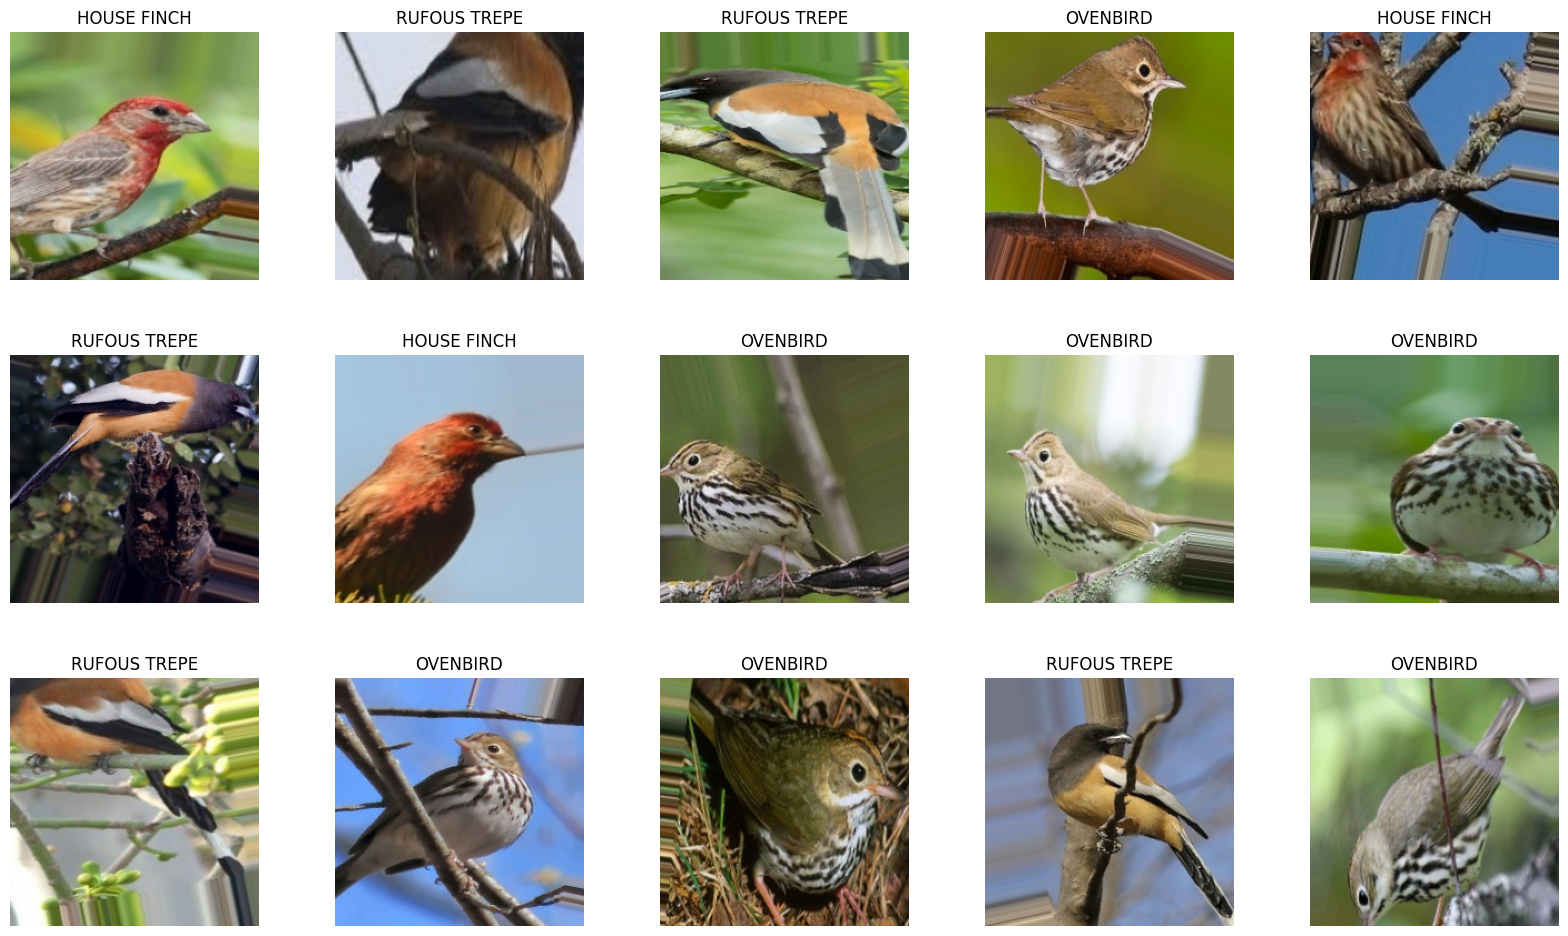

In [9]:
labels = [k for k in train_dataset.class_indices]
sample_generate = train_dataset.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(labels[np.argmax(titles[i],axis=0)])
    plt.axis("off")

### Feature extraction with a pretrained model


We will use the VGG16 model, which is a model trained on the ImageNet dataset, we need to specify some parameters to have a successful feature extraction, we will use the following parameters:

weights: specifies the weight checkpoint from which to initialize the model.

include_top=False: refers to not including the "head" of the model.

input_shape: the shape of the input images.


In [10]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

2023-12-05 23:21:03.690590: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-05 23:21:03.690710: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-05 23:21:03.690743: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-05 23:21:03.691276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 23:21:03.691722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Get the output from the pre-trained VGG16 model and flatten the output
x = layers.Flatten()(conv_base.output)
x = layers.Dense(256, activation='relu')(x)
# Add the final Dense layer with 3 units because of our clases with a softmax activation
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=conv_base.input, outputs=outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation",
        save_best_only=True,
        monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.5581 - accuracy: 0.8710 - auc: 0.9584 - precision: 0.8713 - recall: 0.8642INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


24/24 [==============================] - 17s 486ms/step - loss: 0.5581 - accuracy: 0.8710 - auc: 0.9584 - precision: 0.8713 - recall: 0.8642 - val_loss: 0.0012 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
24/24 [==============================] - 8s 311ms/step - loss: 0.2569 - accuracy: 0.9315 - auc: 0.9849 - precision: 0.9325 - recall: 0.9288 - val_loss: 0.0119 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
24/24 [==============================] - 8s 305ms/step - loss: 0.1564 - accuracy: 0.9435 - auc: 0.9924 - precision: 0.9447 - recall: 0.9422 - val_loss: 0.0983 - val_accuracy: 0.9333 - val_auc: 0.9978 - val_precision: 0.9333 - val_recall: 0.9333
Epoch 4/10
24/24 [==============================] - 7s 301ms/step - loss: 0.1595 - accuracy: 0.9556 - auc: 0.9907 - precision: 0.9569 - recall: 0.9556 - val_loss: 0.0090 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000 - val_r

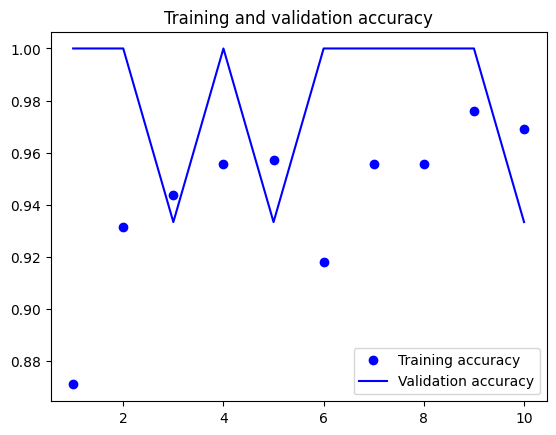

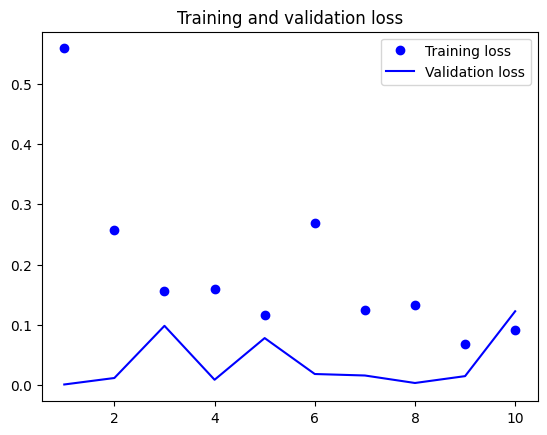

In [36]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [25]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation")
test_loss, test_acc, test_auc, test_precision, test_recall = test_model.evaluate(
    test_dataset, verbose=2)
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test AUC: {test_auc:.3f}")
print(f"Test precision: {test_precision:.3f}")

1/1 - 1s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - 611ms/epoch - 611ms/step
Test loss: 0.003
Test accuracy: 1.000
Test AUC: 1.000
Test precision: 1.000


In [26]:
test_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# Evaluate the model
eval_metrics = test_model.evaluate(test_dataset)

print("Evaluation Metrics:")
print(f"Loss: {eval_metrics[0]}")
print(f"Categorical Accuracy: {eval_metrics[1]}")
print(f"Precision: {eval_metrics[2]}")
print(f"Recall: {eval_metrics[3]}")

1/1 [==============================] - 0s 324ms/step - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000
Evaluation Metrics:
Loss: 0.0033800057135522366
Categorical Accuracy: 1.0
Precision: 1.0
Recall: 1.0


1/1 [==============================] - 0s 36ms/step


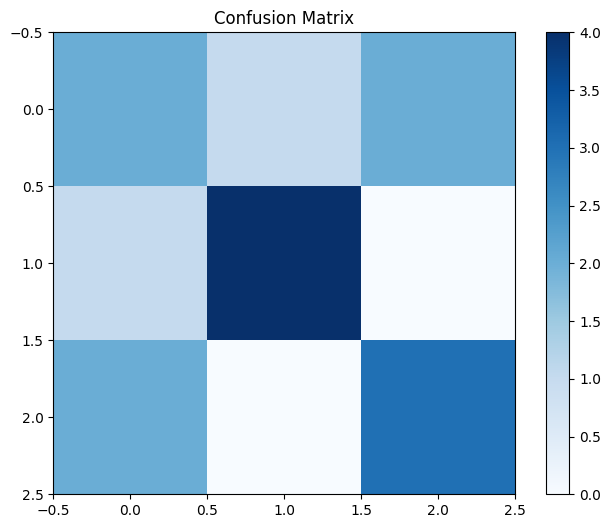

In [45]:
test_dataset.reset()
y_true = test_dataset.classes
y_pred = test_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()
